# BERT Replication notebook.
Replicate the results observed by Warstadt & Bowman, 2019 when training a BERT model on the Corpus of Linguistic Acceptability (CoLA).  This notebook is meant to demonstrate that my implementation of the BERT's training and testing has not crippled the model in such a way that would lead to poor performance on the Acceptability Delta test.

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pathlib import Path
from sklearn.metrics import matthews_corrcoef, mean_squared_error
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import pipeline
sns.set(font_scale=1.5)

In [2]:
# My pretrained and fine-tuned BERT models.
BERT_BASE = '../bert-priming/models/bert-pretrained-cola-control-seed{}'
BERT_LARGE = '../bert-priming/models/bert-cola-large-seed{}'
BERT_LARGE_CASED = '../bert-priming/models/bert-cola-large-cased-seed{}'

# Data of interest.
DATA_FILE = Path('./data/li-adger_sentences.csv')
DATA_OUT_DIR = Path('./output/bert_acc_results_li-adger_sentences.csv')

# CoLA files for validation.
COLA_DEV = Path('./data/CoLA/cola_out_of_domain_dev.csv')
COLA_TEST = Path('./data/CoLA/cola_out_of_domain_test.csv')
COLA_ANNOTATIONS_MAJOR = Path('./data/CoLA/CoLA_grammatical_annotations_major_features.tsv')
COLA_ANNOTATIONS_MINOR = Path('./data/CoLA/CoLA_grammatical_annotations_minor_features.tsv')

# Random seeds used to train BERT.
BERT_BASE_SEEDS = [18, 11, 97, 7, 39, 40, 67, 5, 84, 72]
BERT_LARGE_SEEDS = [134, 167, 168, 177, 182, 189, 191, 195, 203, 204,
                    225, 234, 239, 291, 308, 310, 322, 336, 348, 351]
BERT_LARGE_CASED_SEEDS = [137, 230, 369, 375, 402, 434, 453, 56, 573, 637,
                          72, 748, 839, 84, 854, 870, 893, 919, 961, 974]

# Put all the models together.
models = {BERT_BASE:{"model":"bert-base-uncased", "seeds":BERT_BASE_SEEDS, "color":"blue"},
          BERT_LARGE:{"model":"bert-large-uncased", "seeds":BERT_LARGE_SEEDS, "color":"orange"},
          BERT_LARGE_CASED:{"model":"bert-large-cased", "seeds":BERT_LARGE_CASED_SEEDS, "color":"green"}
         }

In [3]:
## Set up CUDA for training.
if torch.cuda.is_available():  # Tell PyTorch to use the GPU. 
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('Will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Will use the GPU: GeForce RTX 2080 Ti


In [4]:
## Load the .csv file with human data into memory.
sentences = pd.read_csv(DATA_FILE)
print(sentences.head())

# Get ground truth labels for each sentence.
sentences['label'] = (sentences.id.str.contains('g')).astype('int32')

  dataset notes typo?                   id  \
0      LI   NaN   NaN  32.1.martin.1a.g.01   
1      LI   NaN   NaN  32.1.martin.1a.g.02   
2      LI   NaN   NaN  32.1.martin.1a.g.03   
3      LI   NaN   NaN  32.1.martin.1a.g.04   
4      LI   NaN   NaN  32.1.martin.1a.g.05   

                                        sentence  sent_length  
0              Kerry attempted to study physics.            7  
1             Jimmy attempted to weave a basket.            8  
2     Brittany attempted to touch the porcupine.            8  
3  Frank attempted to eat a triple fudge sundae.           10  
4                Kat attempted to keep her mail.            8  


In [42]:
## Load CoLA out of domain dev set and its grammatical annotations.
cola_dev = pd.read_csv(COLA_DEV, index_col=0)
cola_test = pd.read_csv(COLA_TEST, index_col=0)
analysis_set = cola_test.append(cola_dev).reset_index(drop=True)
major_annotations = pd.read_csv(COLA_ANNOTATIONS_MAJOR, sep='\t')
minor_annotations = pd.read_csv(COLA_ANNOTATIONS_MINOR, sep='\t')

In [6]:
## Helper function to apply Sequence Classification pipeline to a Pandas DataFrame.
def sentence_acc_score(dataframe, sent_col='sentence', acc_pipeline=None, binary_labels=True):
    sentences = dataframe[sent_col].values.tolist()
    
    try: # Check whether all the sentences can be processed simultaneously.
        results = pd.DataFrame(acc_pipeline(sentences))
    except: # Batch them if not.
        n = 500 # Batch size.
        results = []
        for i in range(0, len(sentences), n):
            batch = sentences[i:i+n] if i+n < len(sentences) else sentences[i:]
            results += acc_pipeline(batch)
            torch.cuda.empty_cache()
        results = pd.DataFrame(results)
        
    if binary_labels:
        results.label.replace({'LABEL_0':0, 'LABEL_1':1}, inplace=True)
    else:
        results.label.replace({'LABEL_0':-1, 'LABEL_1':1}, inplace=True)
        results.label = results.label * results.score
    
    #print(results.head())
    
    return results

In [7]:
## Helper function to get predictions from all random seeds
## of a model on a dataset of sentences.
def get_all_predictions(sentences, model_dir="", random_seeds=[], device=-1, binary_labels=True):
    try:
        predictions = sentences[['id', 'sentence', 'label']].copy()
    except KeyError:
        predictions = sentences[['sentence', 'label']].copy()
    
    for seed in random_seeds:
        # Load each of the BERT instances trained on CoLA.
        model = model_dir.format(seed)
        bert_pipeline = pipeline(task="sentiment-analysis", model=model, device=device)
        
        # Apply the acceptability score wrapper function onto the DataFrame.
        results = sentence_acc_score(sentences, acc_pipeline=bert_pipeline, 
                                     binary_labels=binary_labels)
        
        # Parse results.
        predictions[model] = results.label
        
        # Clear GPU memory for next run.
        torch.cuda.empty_cache()
        
    return predictions

In [8]:
bert_base_cola_pred = get_all_predictions(analysis_set, model_dir=BERT_BASE, 
                                          random_seeds=BERT_BASE_SEEDS, device=0)
bert_large_cola_pred = get_all_predictions(analysis_set, model_dir=BERT_LARGE, 
                                            random_seeds=BERT_LARGE_SEEDS, device=0)
bert_large_cased_cola_pred = get_all_predictions(analysis_set, model_dir=BERT_LARGE_CASED, 
                                            random_seeds=BERT_LARGE_CASED_SEEDS, device=0)

# Put them all together for parsing.
models[BERT_BASE]["data"] = bert_base_cola_pred
models[BERT_LARGE]["data"] = bert_large_cola_pred
models[BERT_LARGE_CASED]["data"] = bert_large_cased_cola_pred


In [69]:
## Prepare to parse & log everything.

# For calculating Matthews Correlation Coefficient on the CoLA test set.
models[BERT_BASE]["mcc_cola"] = []
models[BERT_LARGE]["mcc_cola"] = []
models[BERT_LARGE_CASED]["mcc_cola"] = []

# To grab the best performing model.
models[BERT_BASE]["max_mcc_cola"] = (0, "column")
models[BERT_LARGE]["max_mcc_cola"] = (0, "column")
models[BERT_LARGE_CASED]["max_mcc_cola"] = (0, "column")

# MCC of average predictions across all random seeds.
models[BERT_BASE]["ensemble_mcc_cola"] = 0
models[BERT_LARGE]["ensemble_mcc_cola"] = 0
models[BERT_LARGE_CASED]["ensemble_mcc_cola"] = 0

# Init empty dataframe for logging.
mcc_features_major = pd.DataFrame(columns=["feature", "seed", "mcc", "model"])
mcc_features_minor = pd.DataFrame(columns=["feature", "seed", "mcc", "model"])

In [70]:
# For parsing.
major_features = ['Simple', 'Predicate', 'Adjunct', 'Argument Type', 'Arg Altern', 
                  'Binding', 'Question', 'Comp Clause', 'Auxiliary', 
                  'to-VP', 'N, Adj', 'S-Syntax', 'Determiner']
minor_features = ['Simple', 'Copula', 'Pred/SC', 'Result/Depictive', 'Particle', 'VP Adjunct', 'NP Adjunct',
                  'Temporal', 'Locative', 'Misc', 'Oblique', 'PP Arg-VP', 'PPArg-NP/AP', 
                  'by-Phrase', 'Expletive', 'High Arity', 'Drop Arg', 'Add Arg',
                  'Passive', 'Imperative', 'Binding:Refl', 'Binding:Other', 'Matrix Q',
                  'Emb Q', 'Complex QP', 'RC', 'Island', 'CP Subj', 'CP Arg VP',
                  'CP Arg NP/AP', 'Non-finite CP', 'No C-izer', 'Deep Embed', 'Neg',
                  'Modal', 'Aux', 'Psuedo-Aux', 'Control', 'Raising', 'VP+Extract',
                  'VP arg-NP/AP', 'Non-finite VP Misc', 'Deverbal', 'Rel NP', 'Trans NP',
                  'Compx NP', 'NNCompd', 'Rel Adj', 'Trans Adj', 'Dislocation',
                  'Info Struc', 'Frag/Paren', 'Coord', 'Subordinate/Cond',
                  'Ellipsis/Anaphor', 'S-Adjunct', 'Quantifier', 'Partitive', 'NPI/FCI',
                  'Comparative', 'Sem  Violation', 'Infl/Agr Violation', 'Extra/Mising Expr']

In [71]:
# Parse the data.
for key, info in models.items():
    num_seeds = len(info['seeds'])
    
    # Collect MCC scores from each random seed and build ensemble prediction.
    ensemble = np.zeros(info["data"].loc[info["data"].sentence.isin(cola_test.sentence)].shape[0])
    for column in info['data'].columns:
        if "seed" not in column: continue # Skip column.
        # Grab only sentences in the CoLA test set.
        subset = info["data"].loc[info["data"].sentence.isin(cola_test.sentence)]
        mcc = matthews_corrcoef(subset.label, subset[column])
        ensemble += subset[column].values
        info["mcc_cola"].append(mcc)
        if mcc > info["max_mcc_cola"][0]:
            info["max_mcc_cola"] = (mcc, column)
    # Set the majority predictions in the ensemble predictions.
    # Note: if there is a tie, the true label is chosen according to Warstadt & Bowman 2019.
    tie = np.equal(ensemble, num_seeds/2)
    ensemble = np.greater(ensemble, num_seeds/2).astype(int)
    ensemble[tie] = subset.label.loc[tie] # tie breaker...
    info["ensemble_mcc_cola"] = matthews_corrcoef(subset.label, ensemble)
    
    # Compute MCC scores by major feature.
    for feature in major_features:
        row = {"feature":feature, "seed":-1, "mcc":-1, "model":info["model"]}
        subset = major_annotations.Sentence.loc[major_annotations[feature] == 1]
        subset = info['data'].loc[info['data'].sentence.isin(subset)]
        for seed in info["seeds"]:
            column = key.format(seed)
            row["seed"] = seed
            row["mcc"] = matthews_corrcoef(subset.label, np.sign(subset[column]))
            mcc_features_major = mcc_features_major.append(row, ignore_index=True)
    
    # Compute MCC scores by minor feature.
    for feature in minor_features:
        row = {"feature":feature, "seed":-1, "mcc":-1, "model":info["model"]}
        subset = minor_annotations.Sentence.loc[minor_annotations[feature] == 1]
        subset = info['data'].loc[info['data'].sentence.isin(subset)]
        for seed in info["seeds"]:
            column = key.format(seed)
            row["seed"] = seed
            row["mcc"] = matthews_corrcoef(subset.label, np.sign(subset[column]))
            if row["mcc"] > 0 and row["mcc"] < 1:
                mcc_features_minor = mcc_features_minor.append(row, ignore_index=True)

C:\Users\hecto\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\hecto\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\hecto\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\hecto\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\hecto\anaconda3\envs\bert_env\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.s

In [72]:
# Print quick stats for each of the models.
print("Now printing model performance (MCC) on the CoLA test set")
for key, info in models.items():
    print("<---------------------------" + info["model"] + "--------------------------->")
    print("| Mean MCC score & std. dev: {}, ({})".format(np.mean(info["mcc_cola"]), np.std(info["mcc_cola"])))
    print("| Max MCC score: ", info["max_mcc_cola"][0])
    print("| Ensemble MCC score:", info["ensemble_mcc_cola"])

Now printing model performance (MCC) on the CoLA test set
<---------------------------bert-base-uncased--------------------------->
| Mean MCC score & std. dev: 0.47848680670405813, (0.018146355671108946)
| Max MCC score:  0.5137060017832944
| Ensemble MCC score: 0.5219077330883684
<---------------------------bert-large-uncased--------------------------->
| Mean MCC score & std. dev: 0.5420971923813005, (0.019377886497184582)
| Max MCC score:  0.583413376986062
| Ensemble MCC score: 0.5782187936324973
<---------------------------bert-large-cased--------------------------->
| Mean MCC score & std. dev: 0.5737270384257215, (0.025968779432036227)
| Max MCC score:  0.6133608843384509
| Ensemble MCC score: 0.5882799000984055


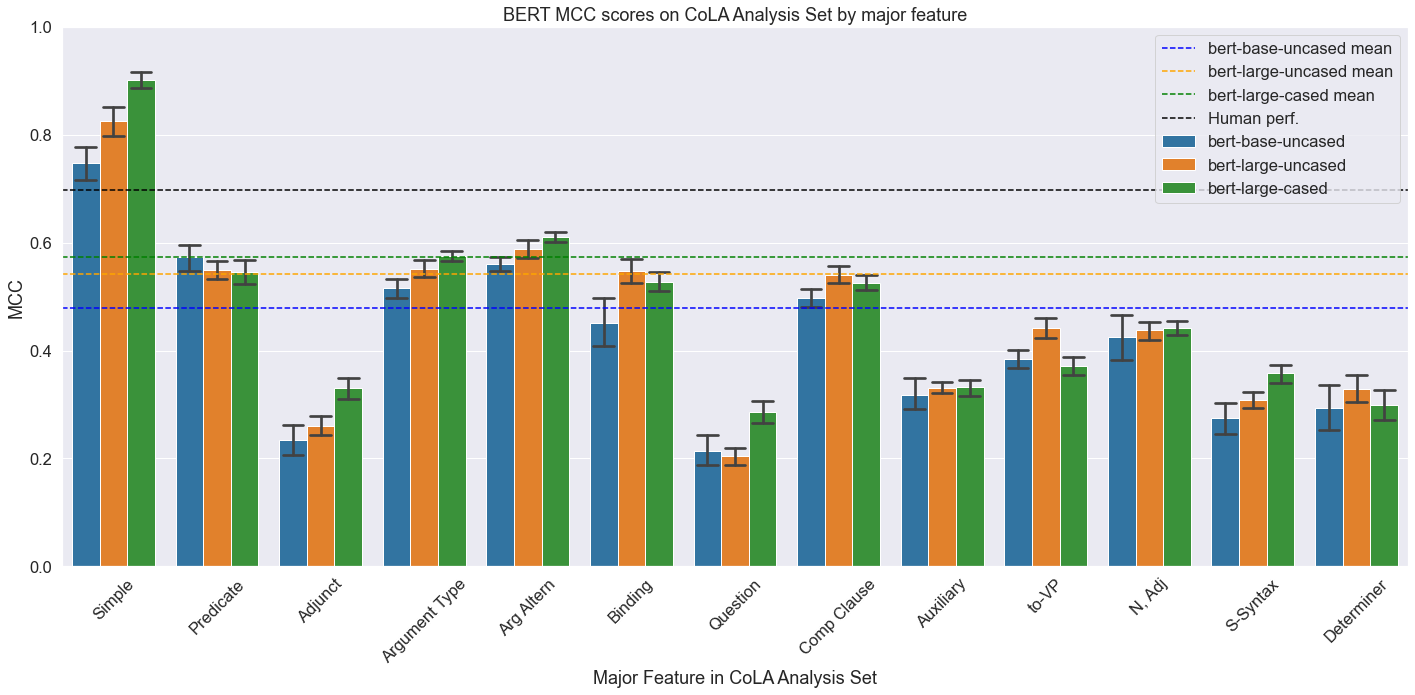

In [84]:
# From Warstadt & Bowman 2019
human_mcc_score = 0.697

fig, ax = plt.subplots(figsize=(20, 10))

# Barplots.
sns.barplot(x='feature', y='mcc', hue='model', data=mcc_features_major, capsize=.2, palette="tab10", ax=ax)
for item in ax.get_xticklabels():
    item.set_rotation(45)

# Average BERT MCC score.
for key, info in models.items():
    ax.axhline(np.mean(info['mcc_cola']), label=info["model"] + " mean", color=info["color"], linestyle="--")

ax.axhline(human_mcc_score, color='black', linestyle='--', label='Human perf.')
#ax.axhline(np.mean(mcc_scores_large), color='orange', linestyle=':', label='BERT_large_avg_mcc')
#ax.axhline(np.mean(mcc_scores_large_cased), color='green', linestyle='-.', label='BERT_large_cased_avg_mcc')

ax.set_ylim([0, 1])

# Titles.
ax.set_title("BERT MCC scores on CoLA Analysis Set by major feature")
ax.set_xlabel("Major Feature in CoLA Analysis Set")
ax.set_ylabel("MCC")


plt.legend()
plt.tight_layout()
plt.savefig("./figures/bert_mcc_scores_cola_major_features.png")
plt.show()

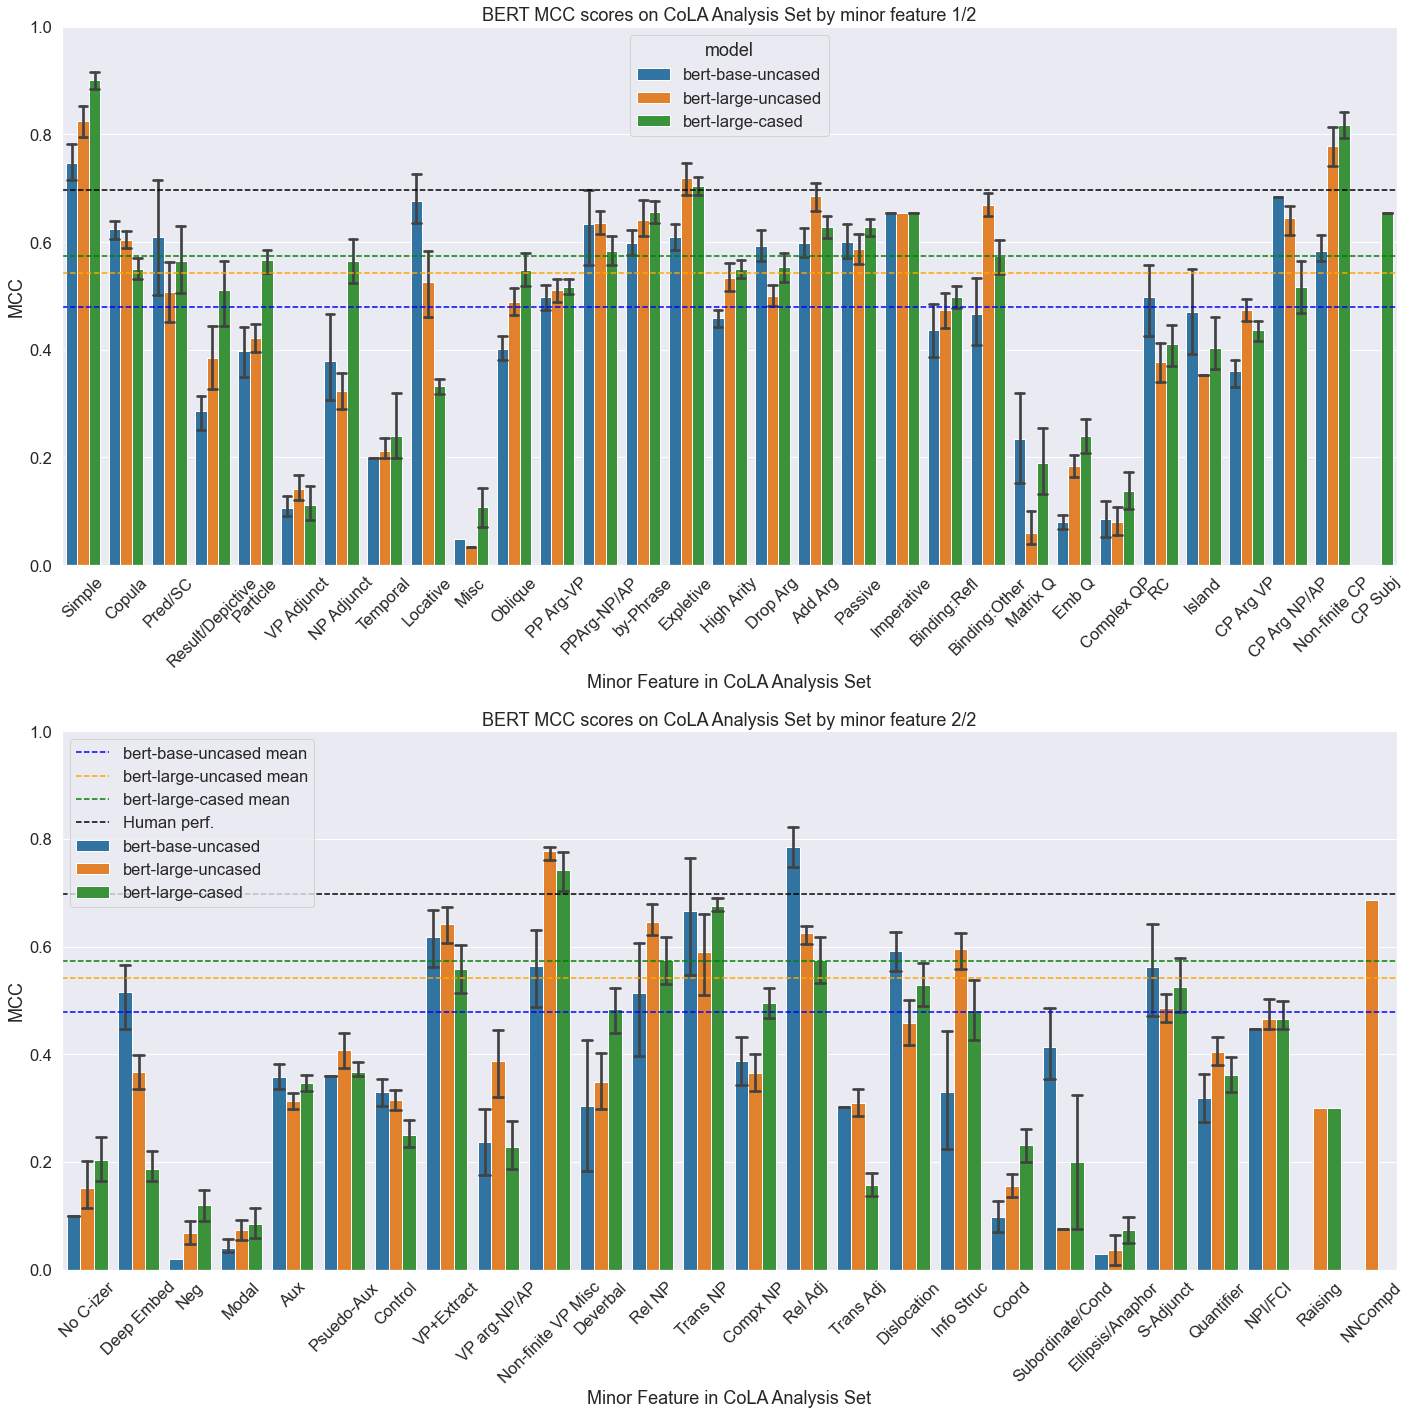

In [90]:
# From Warstadt & Bowman 2019
human_mcc_score = 0.697

fig, axes = plt.subplots(nrows=2, figsize=(20, 10*2))

plot1 = minor_features[0:len(minor_features)//2]
plot2 = minor_features[len(minor_features)//2:]

# Barplots.
sns.barplot(x='feature', y='mcc', hue='model', data=mcc_features_minor.loc[mcc_features_minor.feature.isin(plot1)],
            capsize=.2, palette="tab10", ax=axes[0])
sns.barplot(x='feature', y='mcc', hue='model', data=mcc_features_minor.loc[mcc_features_minor.feature.isin(plot2)],
            capsize=.2, palette="tab10", ax=axes[1])

i = 0
for ax in axes:
    i += 1
    
    for item in ax.get_xticklabels():
        item.set_rotation(45)

    # Average BERT MCC score.
    for key, info in models.items():
        ax.axhline(np.mean(info['mcc_cola']), label=info["model"] + " mean", color=info["color"], linestyle="--")

    ax.axhline(human_mcc_score, color='black', linestyle='--', label='Human perf.')

    ax.set_ylim([0, 1])

    # Titles.
    ax.set_title(f"BERT MCC scores on CoLA Analysis Set by minor feature {i}/2")
    ax.set_xlabel("Minor Feature in CoLA Analysis Set")
    ax.set_ylabel("MCC")

#fig.suptitle("BERT MCC performance on the CoLA analysis Set by minor feature",y=1.05)
plt.legend()
plt.tight_layout()
plt.savefig("./figures/bert_mcc_scores_cola_minor_features.png")
plt.show()

It seems my BERT implementations are fairly in line with the results of Warstadt & Bowman 2019.  Because these results agree with theirs, I will now proceed to gather acceptability judgements from each of the above BERT models on the LI-Adger sentences.  Particularly, I will scale those judgements according to each model's _confidence_ (the output of the softmax before choosing the final categorical label).  Thus, each model's output for a given sentence will be as follows:
$$ model(s_i) = pred_i * conf_i $$
where $pred_i$ is the output label (+1 for acceptable, -1 for unacceptable) and $conf_i$ is the softmax output at the final layer of the model before choosing the label.

In [85]:
## Run acceptability pipeline on the DataFrame of sentences.
for key, info in models.items():
    
    predictions = get_all_predictions(sentences, model_dir=key, random_seeds=info["seeds"],
                                        device=0, binary_labels=False)
    
    # Check that the order of the sentences did not change in processing.
    if not sentences.sentence.equals(predictions.sentence):
        print("WARNING: sentence predictions out of order.")
        print("Skipping this iteration...")
        continue
    
    # Average the predictions across all random seeds. and calculate MCC scores.
    '''
    predictions['average'] = 0
    info['mcc_li-adger'] = []
    for column in predictions:
        if "seed" not in column: continue
        predictions.average += predictions[column]/len(info["seeds"])
        binary_predictions = (np.sign(predictions[column]) + 1) / 2 # Convert back to 0/1.
        info['mcc_li-adger'].append(matthews_corrcoef(predictions.label, binary_predictions))
    '''
    # Get predictions from the best performing random seed on CoLA test set.
    best = predictions[info["max_mcc_cola"][1]]
    binary_predictions = (np.sign(best) + 1) / 2 # Convert back to 0/1.
    info['mcc_li-adger'] = matthews_corrcoef(predictions.label, binary_predictions)
    sentences[info['model'] + '_acc'] = best
    sentences[info['model'] + '_acc_zscores'] = (best - best.mean())/best.std(ddof=0)

    
    '''
    # Copy the sentences DataFrame without the label column.
    new_data = sentences.drop(labels=['label'], axis=1).rename({"sentence":"regularizedSentence"}, axis=1)
    new_data['full.measure.name'] = info['model']
    new_data['corpus'] = 'CoLA'
    new_data['measure'] = 'acceptability'
    #new_data['probability'] = predictions.average.values
    # ^^^NOTE: I will be using the BEST predictor on the CoLA test set, not the average
    # prediction across all random seeds.
    new_data['probability'] = predictions[info["max_mcc_cola"][1]]

    # Save the results.
    data = data.append(new_data)
    '''

    ## Console output ##
    print("<----------- {} ----------->".format(info["model"].upper()))
    print("| MCC score on the LI-Adger dataset: {}".format(info['mcc_li-adger']))
    #print("{} MCC score (average) on LI-Adger dataset:".format(info["model"]))
    #print(np.mean(info["mcc_li-adger"]))
    #print("{} max MCC score on LI-Adger dataset:".format(info["model"]))
    #print(np.max(info["mcc_li-adger"]))
    #print("{} standard deviation in MCC scores on LI-Adger:".format(info["model"]))
    #print(np.std(info["mcc_li-adger"]))

<----------- BERT-BASE-UNCASED ----------->
| MCC score on the LI-Adger dataset: 0.5526028100496759
<----------- BERT-LARGE-UNCASED ----------->
| MCC score on the LI-Adger dataset: 0.5760314534458189
<----------- BERT-LARGE-CASED ----------->
| MCC score on the LI-Adger dataset: 0.5947401297473346


In [13]:
## Parse the models dictionary into DataFrame in order to plot the MCC scores.
mcc_df = pd.DataFrame(data=[], columns=["model", "dataset", "mcc"])
for key, info in models.items():
    for mcc_val in info["mcc_cola"]:
        row = {"model":info["model"], "dataset":"cola_test_set", "mcc":mcc_val}
        mcc_df = mcc_df.append(row, ignore_index=True)
    for mcc_val in info["mcc_li-adger"]:
        row = {"model":info["model"], "dataset":"li-adger", "mcc":mcc_val}
        mcc_df = mcc_df.append(row, ignore_index=True)

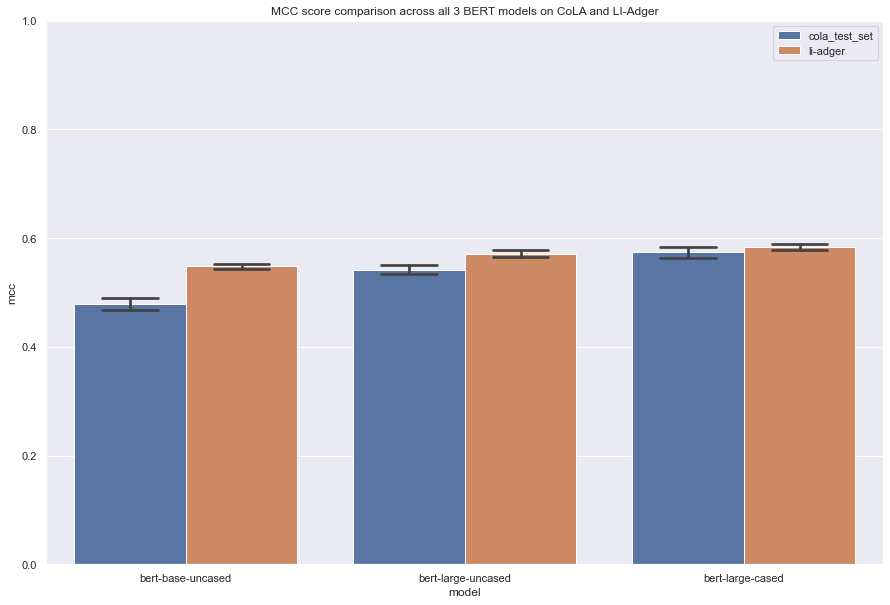

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))

# Barplots.
sns.barplot(x='model', y='mcc', hue='dataset', data=mcc_df, capsize=.2, ax=ax)
ax.set_title("MCC score comparison across all 3 BERT models on CoLA and LI-Adger")

ax.set_ylim([0, 1])
plt.legend()
plt.show()

In [15]:
sentences.head()

,dataset,notes,typo?,id,sentence,label,bert-base-uncased_acc,bert-base-uncased_acc_zscores,bert-large-uncased_acc,bert-large-uncased_acc_zscores,bert-large-cased_acc,bert-large-cased_acc_zscores
0,LI,NaN,NaN,32.1.martin.1a.g.01,Kerry attempted to study physics.,1,0.997605,0.694712,0.999213,0.723134,0.998873,0.732340
1,LI,NaN,NaN,32.1.martin.1a.g.02,Jimmy attempted to weave a basket.,1,0.997158,0.694216,0.999460,0.723399,0.999463,0.732970
2,LI,NaN,NaN,32.1.martin.1a.g.03,Brittany attempted to touch the porcupine.,1,0.997596,0.694701,0.999517,0.723460,0.999484,0.732993
3,LI,NaN,NaN,32.1.martin.1a.g.04,Frank attempted to eat a triple fudge sundae.,1,0.997306,0.694380,0.999664,0.723617,0.999592,0.733108
4,LI,NaN,NaN,32.1.martin.1a.g.05,Kat attempted to keep her mail.,1,0.994997,0.691823,0.998888,0.722786,0.980625,0.712833


In [16]:
sentences.to_csv(DATA_OUT_DIR)

In [17]:
## Check for instability in BERT large cased.
seeds = models[BERT_LARGE_CASED]["seeds"]
predictions = get_all_predictions(sentences, model_dir=BERT_LARGE_CASED, random_seeds=seeds,
                                  device=0, binary_labels=True)
# To track the number of flipping sentences.
predictions["flips"] = 0
predictions["num_flips"] = 0
flip_hist = []
for i in range(len(seeds)):
    seed1 = seeds[i]
    seed2 = seeds[i+1] if i+1 < len(seeds) else seeds[0]
    
    # Will return NaN values for rows that did not change.
    delta = predictions[BERT_LARGE_CASED.format(seed1)].compare(
        predictions[BERT_LARGE_CASED.format(seed2)], keep_shape=True)
    
    #print(delta)
    
    # Merge the two columns.  Rows that changed value will have a new value of 1.
    # Rows that didn't will still be NaN.
    delta = delta.self + delta.other
    #print(delta)
    
    # Replace NaN with 0 for boolean logic.
    delta.fillna(0, inplace=True)
    
    # Perform boolean addition on the current record of flipping sentences.
    predictions.flips = predictions.flips | delta.astype('int32')
    
    # Perform normal addition in order to tally how much each sentence flipped.
    predictions.num_flips += delta.astype('int32')
    
    # Get total of sentences that have flipped so far.
    flip_hist.append(predictions.flips.sum()/predictions.flips.shape)   

print("Total number of flipping sentences:")
print("{} / {} ".format(predictions.flips.sum(), predictions.flips.shape[0]))

Total number of flipping sentences:
1031 / 4178 


In [18]:
## Get all examples of sentences that flip.
acrobatic_sentences = predictions[['id', 'sentence', 'num_flips']].loc[predictions.flips == 1]
acrobatic_sentences['flip_rate'] = acrobatic_sentences.num_flips / (len(models[BERT_LARGE_CASED]["seeds"])/2)

print(acrobatic_sentences)

                         id                                         sentence  \
48    32.1.martin.26a.??.01        Ginny remembered to have bought the beer.   
51    32.1.martin.26a.??.04          Bobby planned to have attended college.   
53    32.1.martin.26a.??.06  Scott intended to have run for class president.   
54    32.1.martin.26a.??.07   Vanessa refused to have taken out the garbage.   
55    32.1.martin.26a.??.08          Michael managed to have driven his car.   
...                     ...                                              ...   
4138             ch9.4.g.01                            Who did Nancy poison?   
4146            ch9.83.*.01                 I wondered could we leave early.   
4149            ch9.83.*.04          I wondered could we find a replacement.   
4152            ch9.83.*.07    I wondered could we trust the weather report.   
4162         ch9.84-85.*.01                 I wondered who did Nancy poison.   

      num_flips  flip_rate  
48        

In [19]:
acrobatic_sentences.to_csv("./output/bert-large-cased_acrobatic_sentences.csv")